### Import Statements

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Loading the Dataset

In [4]:
uci_data = pd.read_csv('heart_disease_uci.csv')

In [5]:
uci_data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [6]:
uci_data.shape

(920, 16)

### Dropping irrelevant columns
Now it has 14 columns instead of 16

In [7]:
df2 = uci_data.drop(['id', 'dataset'], axis=1)

In [8]:
df2['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [9]:
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Label Encoding categorical values

In [10]:
categorical_columns = ['cp', 'restecg', 'slope', 'thal', 'ca']
label_encoders = {}
for column in categorical_columns:
    encoder = LabelEncoder()
    non_null_mask = df2[column].notna()
    non_null_values = df2[column][non_null_mask]
    encoded_values = encoder.fit_transform(non_null_values)
    df2[column] = pd.Series(index=df2.index, dtype=float)
    df2.loc[non_null_mask, column] = encoded_values
    label_encoders[column] = encoder

    print(f"\nEncoding for {column}:")
    print(f"Null values: {df2[column].isna().sum()}")
    for i, label in enumerate(encoder.classes_):
        print(f"{label} -> {i}")

# Print sample of encoded data
print("\nSample of encoded data:")
print(df2[categorical_columns].head())
print("\nNull value counts:")
print(df2[categorical_columns].isna().sum())


Encoding for cp:
Null values: 0
asymptomatic -> 0
atypical angina -> 1
non-anginal -> 2
typical angina -> 3

Encoding for restecg:
Null values: 2
lv hypertrophy -> 0
normal -> 1
st-t abnormality -> 2

Encoding for slope:
Null values: 309
downsloping -> 0
flat -> 1
upsloping -> 2

Encoding for thal:
Null values: 486
fixed defect -> 0
normal -> 1
reversable defect -> 2

Encoding for ca:
Null values: 611
0.0 -> 0
1.0 -> 1
2.0 -> 2
3.0 -> 3

Sample of encoded data:
    cp  restecg  slope  thal   ca
0  3.0      0.0    0.0   0.0  0.0
1  0.0      0.0    1.0   1.0  3.0
2  0.0      0.0    1.0   2.0  2.0
3  2.0      1.0    0.0   1.0  0.0
4  1.0      0.0    2.0   1.0  0.0

Null value counts:
cp           0
restecg      2
slope      309
thal       486
ca         611
dtype: int64


### Visualisations

In [11]:
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Text(0.5, 1.0, 'Distribution of Heart Disease Classes')

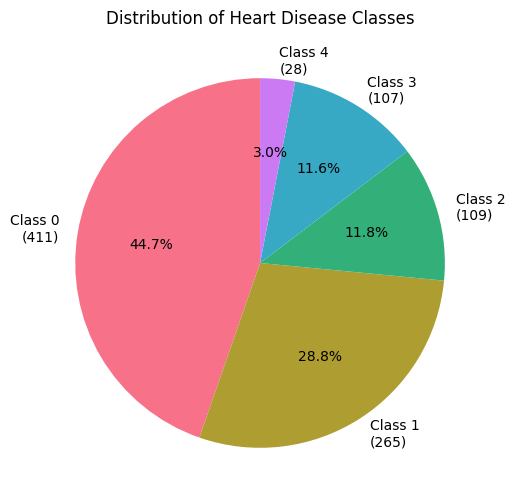

In [12]:
plt.figure(figsize=(8, 6))
target_counts = uci_data['num'].value_counts()
plt.pie(target_counts, labels=[f'Class {i}\n({count})' for i, count in enumerate(target_counts)],autopct='%1.1f%%',colors=sns.color_palette('husl', len(target_counts)),startangle=90)
plt.title('Distribution of Heart Disease Classes')

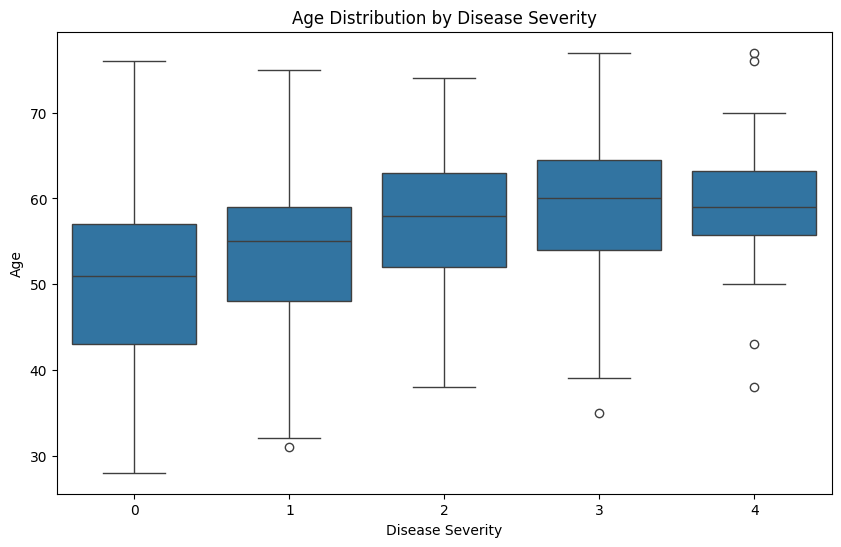

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=uci_data, x='num', y='age')
plt.title('Age Distribution by Disease Severity')
plt.xlabel('Disease Severity')
plt.ylabel('Age')
plt.show()
#Increase in age seems to cause increase in severity

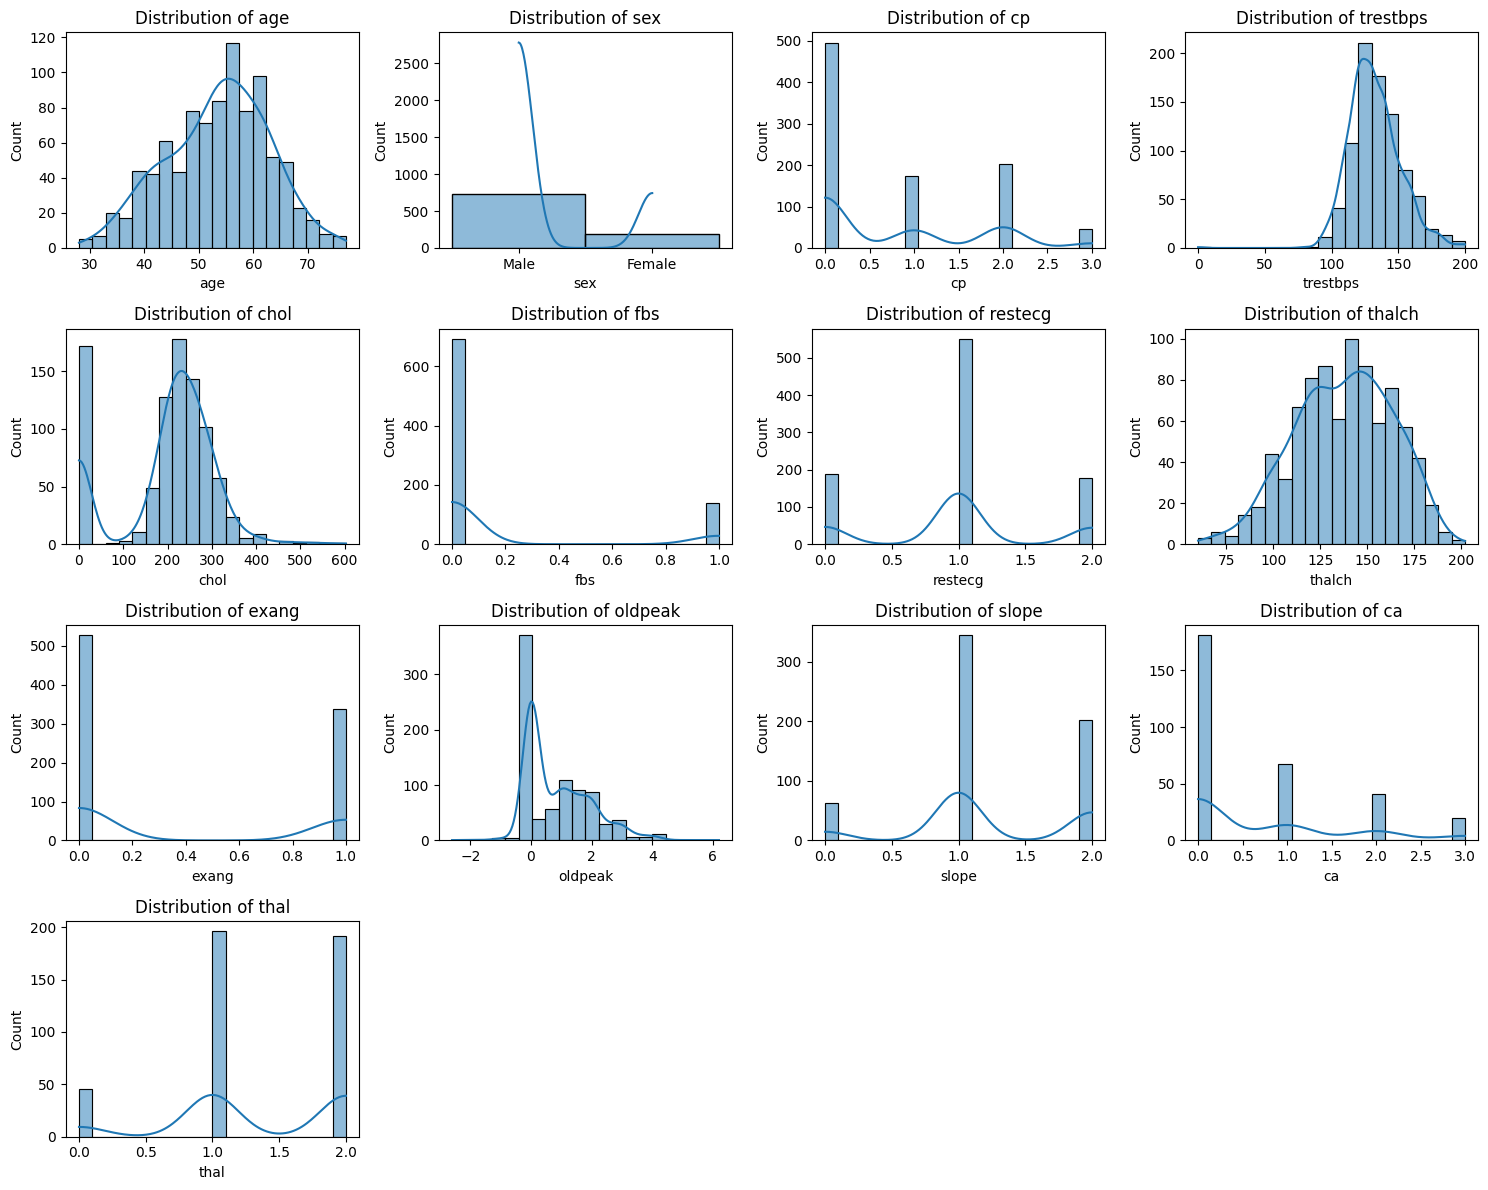

In [14]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features[:-1], 1):  # Excluding target 'num'
    plt.subplot(4, 4, i)
    sns.histplot(df2[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()

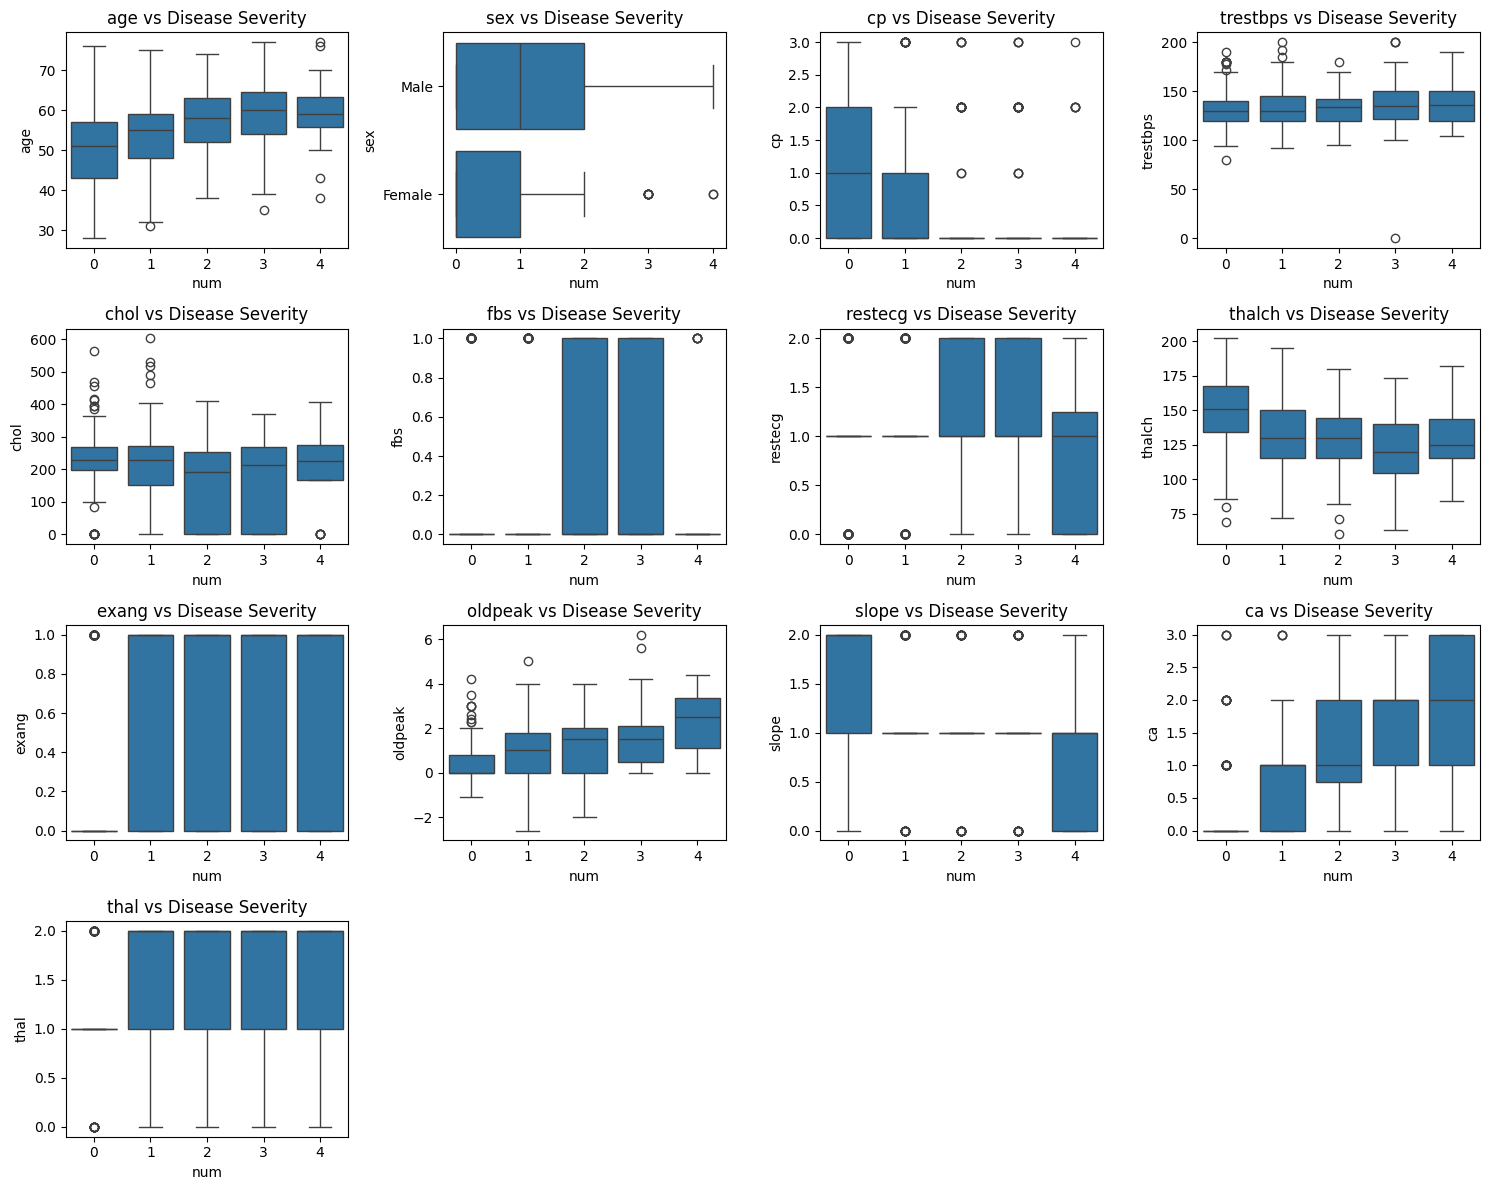

In [15]:
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='num', y=feature, data=df2)
    plt.title(f'{feature} vs Disease Severity')
plt.tight_layout()
plt.show()

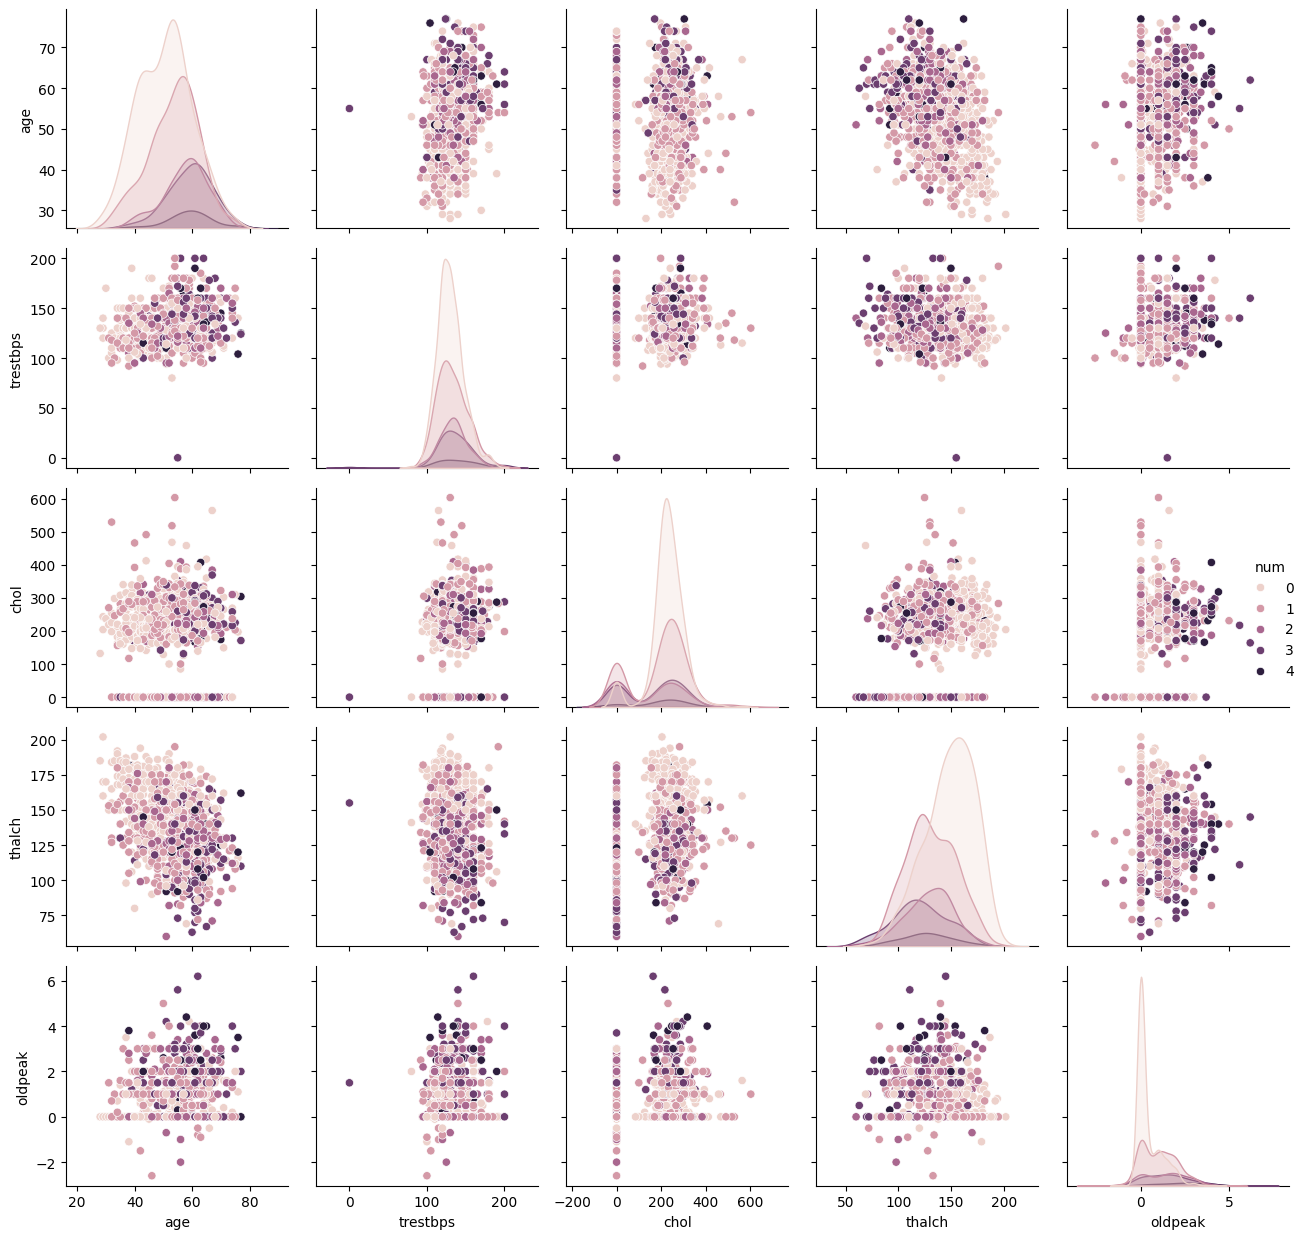

In [16]:
continuous_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num']
sns.pairplot(df2[continuous_features], hue='num', diag_kind='kde')
plt.tight_layout()
plt.show()

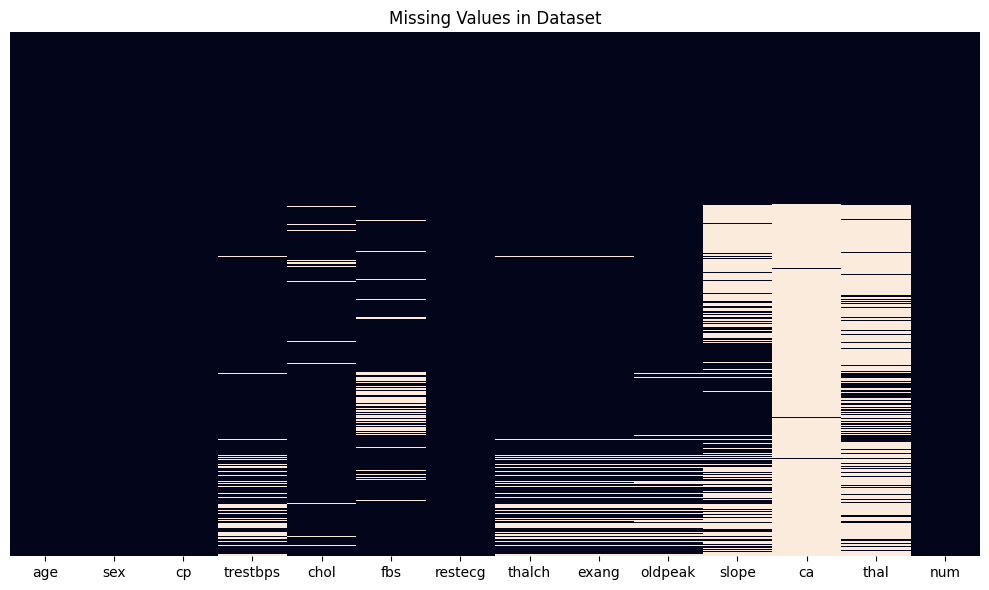

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df2[features].isnull(), yticklabels=False, cbar=False)
plt.title('Missing Values in Dataset')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age vs Max Heart Rate by Disease')

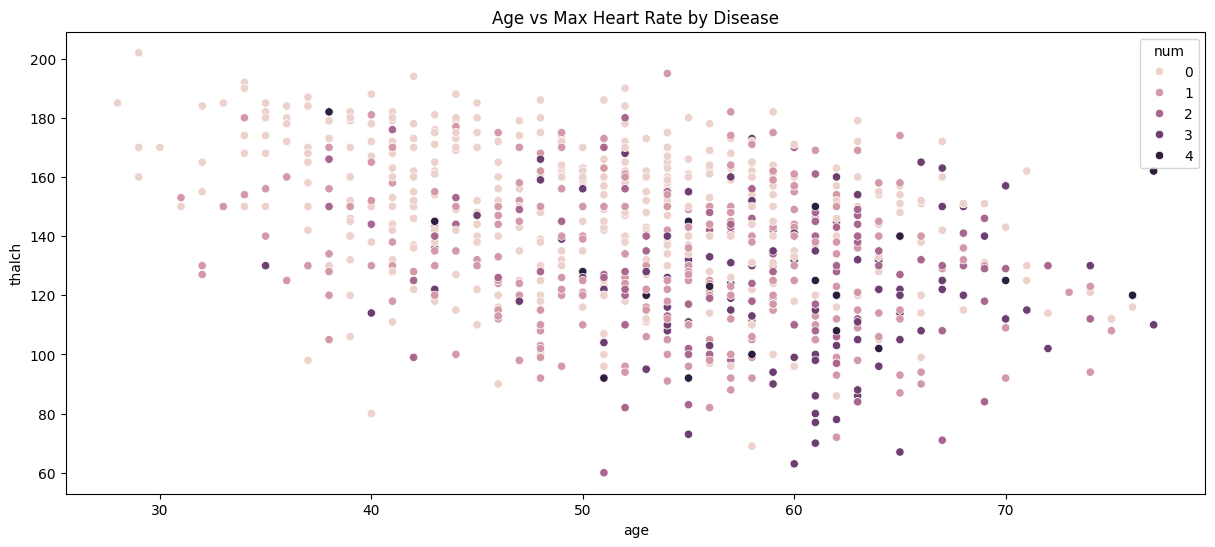

In [18]:
plt.figure(figsize=(50,6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=df2, x='age', y='thalch', hue='num')
plt.title('Age vs Max Heart Rate by Disease')

Text(0.5, 1.0, 'Age vs ST Depression by Disease')

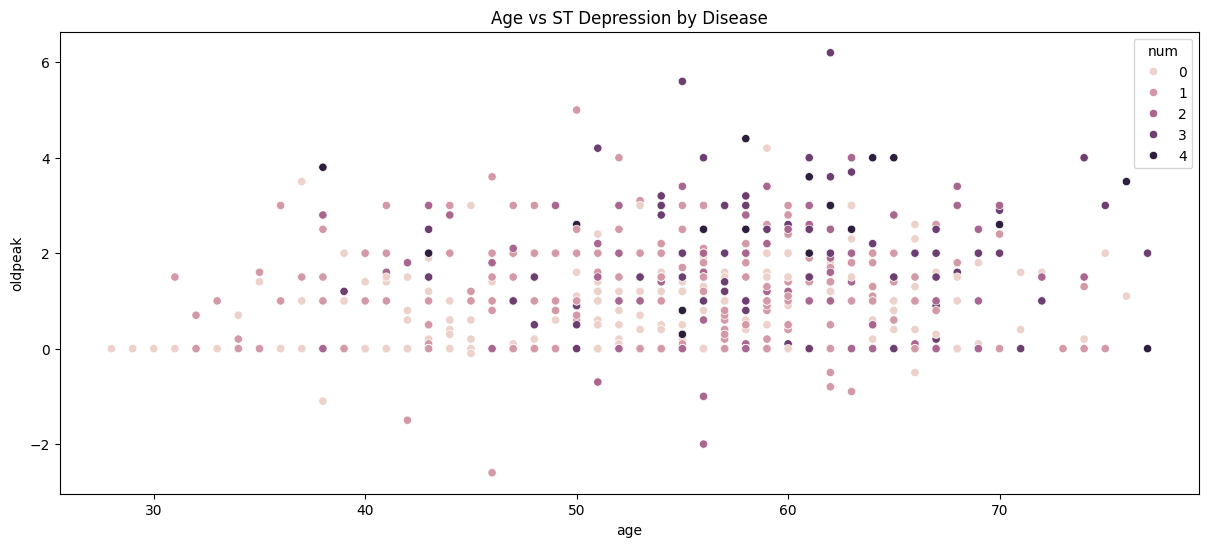

In [19]:
plt.figure(figsize=(50,6))
plt.subplot(1, 3, 2)
sns.scatterplot(data=df2, x='age', y='oldpeak', hue='num')
plt.title('Age vs ST Depression by Disease')

### Change logically flawed values to null

In [20]:
null_percentage = (df2['chol'].isnull().sum() / len(df2)) * 100
print(f"Percentage of null values in cholesterol: {null_percentage:.2f}%")

Percentage of null values in cholesterol: 3.26%


In [21]:
zero_percentage = (df2['chol'] == 0).sum() / len(df2) * 100
print(f"Percentage of zero values in cholesterol: {zero_percentage:.2f}%")

Percentage of zero values in cholesterol: 18.70%


In [22]:
print("\nBefore converting zeros to NaN:")
print(df2['chol'].describe())


Before converting zeros to NaN:
count    890.000000
mean     199.130337
std      110.780810
min        0.000000
25%      175.000000
50%      223.000000
75%      268.000000
max      603.000000
Name: chol, dtype: float64


In [23]:
df2['chol'] = df2['chol'].replace(0, np.nan)
print("\nAfter converting zeros to NaN:")
print(df2['chol'].describe())

final_null_percentage = (df2['chol'].isnull().sum() / len(df2)) * 100
print(f"\nFinal percentage of missing values: {final_null_percentage:.2f}%")


After converting zeros to NaN:
count    718.000000
mean     246.832869
std       58.527062
min       85.000000
25%      210.000000
50%      239.500000
75%      276.750000
max      603.000000
Name: chol, dtype: float64

Final percentage of missing values: 21.96%



Strongest correlations:


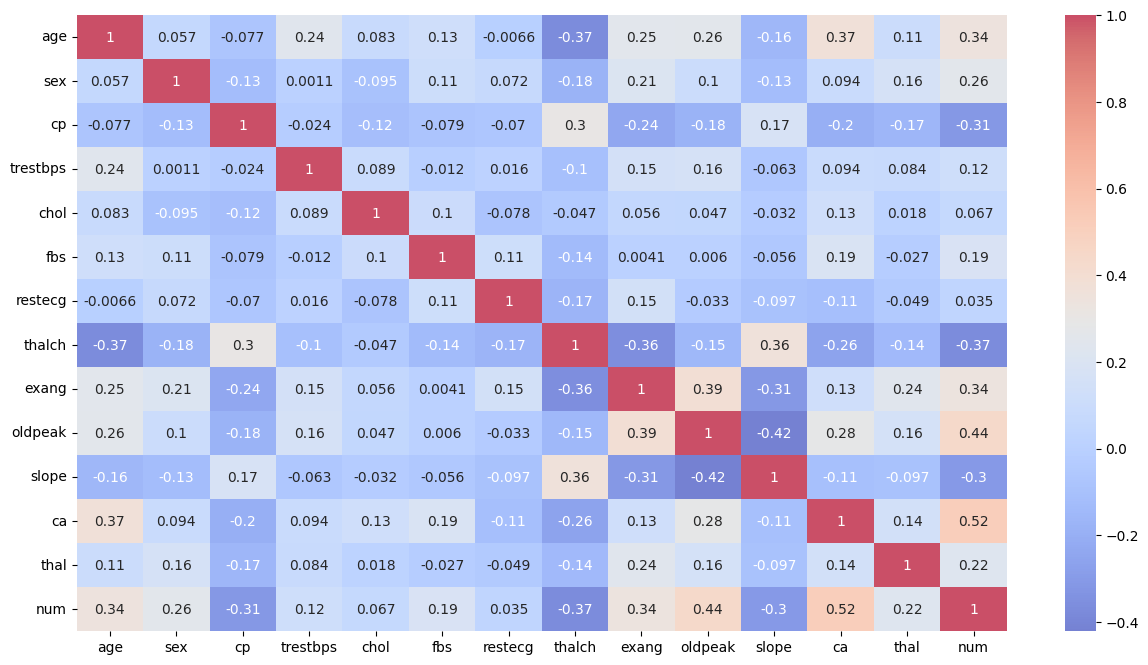

In [24]:
sns.set_palette("coolwarm")
categorical_vals = df2.select_dtypes(include=['object', 'category']).columns
for col in categorical_vals:
    df2[col] = LabelEncoder().fit_transform(df2[col])


correlation_matrix = df2.corr()
corr_features = correlation_matrix.index 
print("\nStrongest correlations:")
plt.figure(figsize=(15, 8))
sns.heatmap(df2[corr_features].corr(), annot=True, cmap='coolwarm', alpha=0.7, square=False)
plt.show()

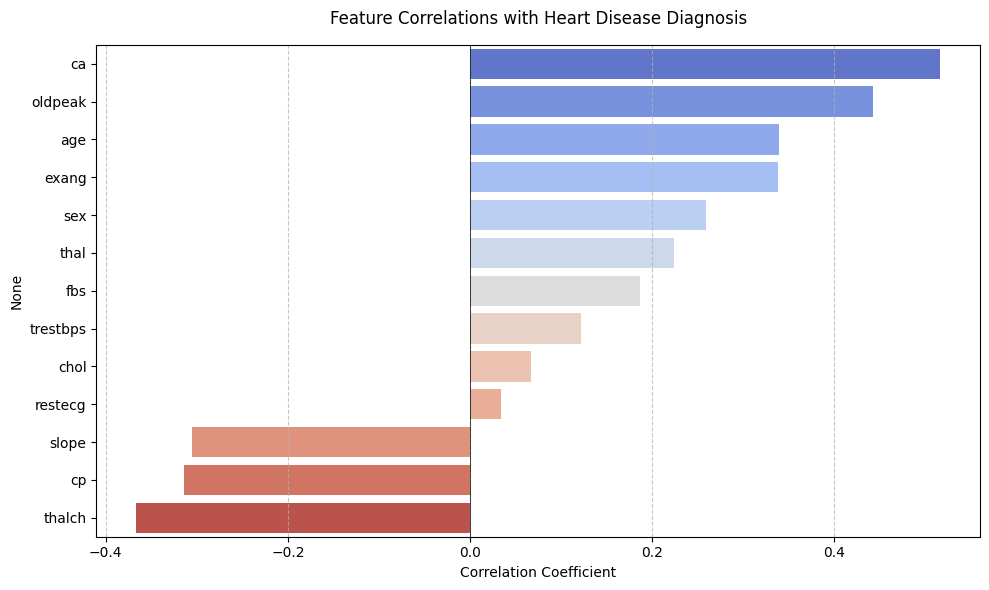


Correlations with num:
ca: 0.516
oldpeak: 0.443
age: 0.340
exang: 0.338
sex: 0.259
thal: 0.224
fbs: 0.187
trestbps: 0.122
chol: 0.067
restecg: 0.035
slope: -0.305
cp: -0.315
thalch: -0.366


In [25]:
correlations_with_num = df2.corr()['num'].sort_values(ascending=False)
correlations_with_num = correlations_with_num.drop('num')
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_num.values, 
            y=correlations_with_num.index,
            palette='coolwarm', hue=correlations_with_num.index, legend=False)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Feature Correlations with Heart Disease Diagnosis', pad=15)
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()
print("\nCorrelations with num:")
for feature, correlation in correlations_with_num.items():
    print(f"{feature}: {correlation:.3f}")

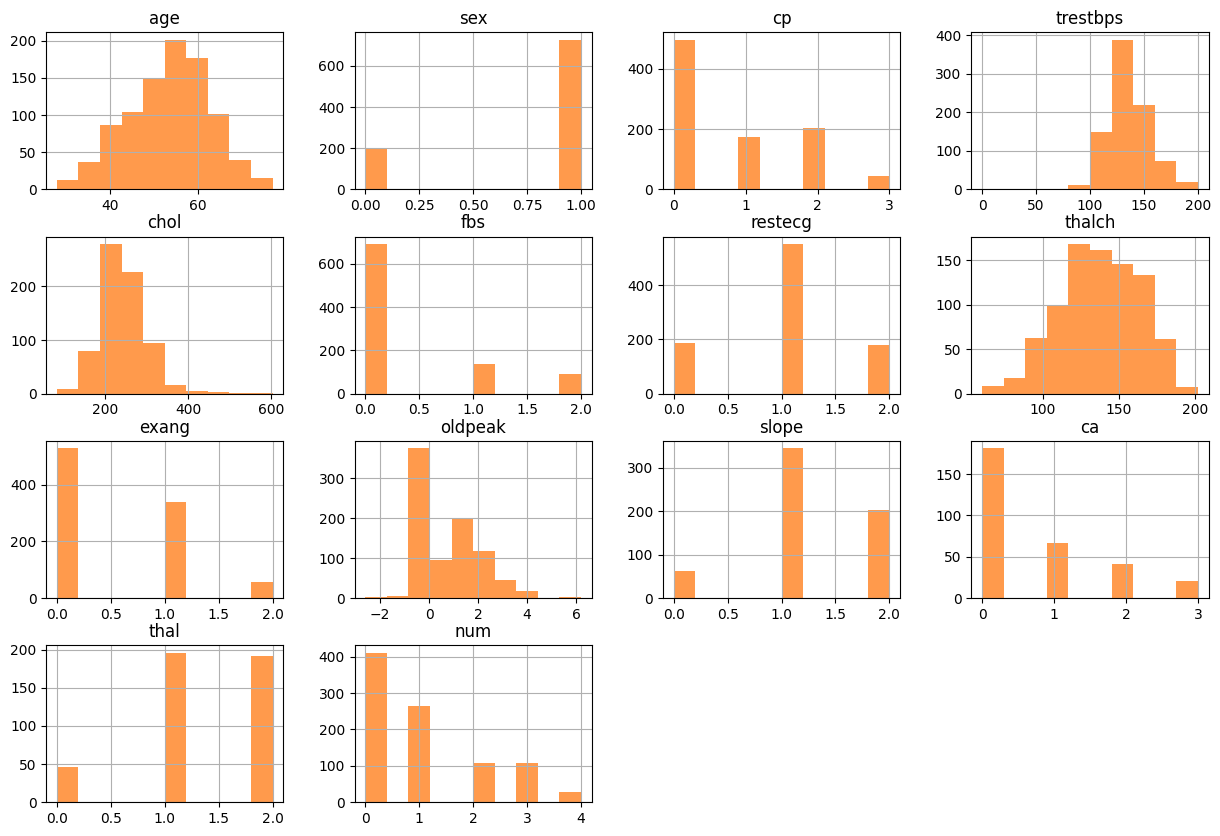

In [26]:
df2.hist(figsize=(15, 10), color='#FF6F00', alpha=0.7)
plt.show()

### Exploring Correlations

In [27]:
df2.groupby('ca')['num'].describe()

,count,mean,std,min,25%,50%,75%,max
ca,,,,,,,,
0.0,181.0,0.453039,0.903237,0.0,0.0,0.0,1.00,4.0
1.0,67.0,1.298507,1.180844,0.0,0.0,1.0,2.00,4.0
2.0,41.0,1.902439,1.241066,0.0,1.0,2.0,3.00,4.0
3.0,20.0,2.300000,1.417930,0.0,1.0,2.5,3.25,4.0


In [28]:
df2.groupby('cp')['num'].describe()

,count,mean,std,min,25%,50%,75%,max
cp,,,,,,,,
0.0,496.0,1.443548,1.132102,0.0,1.0,1.0,2.0,4.0
1.0,174.0,0.183908,0.527372,0.0,0.0,0.0,0.0,3.0
2.0,204.0,0.661765,1.063644,0.0,0.0,0.0,1.0,4.0
3.0,46.0,0.717391,1.025520,0.0,0.0,0.0,1.0,4.0


### Analysing Missing values

In [29]:
missing_values = df2.isnull().sum()
missing_percentage = (df2.isnull().sum() / len(df2)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
})
missing_info = missing_info[missing_info['Missing Values'] > 0]
print("Columns with missing values:")
if len(missing_info) > 0:
    print(missing_info)
else:
    print("No missing values found in the dataset")
total_missing = df2.isnull().sum().sum()
total_cells = np.product(df2.shape)
print(f"\nTotal missing values: {total_missing}")
print(f"Total percentage: {(total_missing/total_cells*100):.2f}% of all cells")

Columns with missing values:
          Missing Values  Percentage
trestbps              59        6.41
chol                 202       21.96
restecg                2        0.22
thalch                55        5.98
oldpeak               62        6.74
slope                309       33.59
ca                   611       66.41
thal                 486       52.83

Total missing values: 1786
Total percentage: 13.87% of all cells


In [30]:
columns_to_impute = missing_percentage[missing_percentage < 10].index
if len(columns_to_impute) > 0:
    imputer = SimpleImputer(strategy='median')
    df2[columns_to_impute] = imputer.fit_transform(df2[columns_to_impute])
    print("\nValues used for imputation:")
    for col, value in zip(columns_to_impute, imputer.statistics_):
        print(f"{col}: {value}")
    final_missing = df2[columns_to_impute].isnull().sum()
    print("\nRemaining missing values in imputed columns:")
    print(final_missing)
else:
    print("\nNo columns found with less than 10% missing values")


Values used for imputation:
age: 54.0
sex: 1.0
cp: 0.0
trestbps: 130.0
fbs: 0.0
restecg: 1.0
thalch: 140.0
exang: 0.0
oldpeak: 0.5
num: 1.0

Remaining missing values in imputed columns:
age         0
sex         0
cp          0
trestbps    0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64


In [31]:
columns_to_impute = missing_percentage[missing_percentage < 20].index
if len(columns_to_impute) > 0:
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
    original_values = df2[columns_to_impute].copy()
    df2[columns_to_impute] = knn_imputer.fit_transform(df2[columns_to_impute])
    print("\nSummary of changes:")
    for col in columns_to_impute:
        print(f"\nColumn: {col}")
        print(f"Missing values before: {original_values[col].isnull().sum()}")
        print(f"Missing percentage: {missing_percentage[col]:.2f}%")
        print("\nStatistics before imputation:")
        print(original_values[col].describe().round(2))
        print("\nStatistics after imputation:")
        print(df2[col].describe().round(2))
    final_missing = df2[columns_to_impute].isnull().sum()
    print("\nRemaining missing values in imputed columns:")
    print(final_missing)
else:
    print("\nNo columns found with less than 20% missing values")


Summary of changes:

Column: age
Missing values before: 0
Missing percentage: 0.00%

Statistics before imputation:
count    920.00
mean      53.51
std        9.42
min       28.00
25%       47.00
50%       54.00
75%       60.00
max       77.00
Name: age, dtype: float64

Statistics after imputation:
count    920.00
mean      53.51
std        9.42
min       28.00
25%       47.00
50%       54.00
75%       60.00
max       77.00
Name: age, dtype: float64

Column: sex
Missing values before: 0
Missing percentage: 0.00%

Statistics before imputation:
count    920.00
mean       0.79
std        0.41
min        0.00
25%        1.00
50%        1.00
75%        1.00
max        1.00
Name: sex, dtype: float64

Statistics after imputation:
count    920.00
mean       0.79
std        0.41
min        0.00
25%        1.00
50%        1.00
75%        1.00
max        1.00
Name: sex, dtype: float64

Column: cp
Missing values before: 0
Missing percentage: 0.00%

Statistics before imputation:
count    920.00
mea

In [32]:
def rf_impute(df):
    # Make a copy of the dataframe
    df_imputed = df.copy()
    
    # Get columns with missing values
    cols_with_missing = df.columns[df.isnull().any()].tolist()
    
    print("Columns with missing values:")
    for col in cols_with_missing:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        print(f"{col}: {missing_count} values ({missing_percent:.2f}%)")

    # Iterate through each column with missing values
    for col in cols_with_missing:
        # Create train and test masks
        train_mask = ~df[col].isnull()
        test_mask = df[col].isnull()
        
        # Prepare training data
        # Use all other columns as features
        feature_cols = [c for c in df.columns if c != col]
        
        # Split into train and test
        X_train = df_imputed.loc[train_mask, feature_cols]
        y_train = df_imputed.loc[train_mask, col]
        X_test = df_imputed.loc[test_mask, feature_cols]
        
        # Initialize and train Random Forest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        
        # Handle any missing values in features by using mean imputation for training
        feature_means = X_train.mean()
        X_train = X_train.fillna(feature_means)
        X_test = X_test.fillna(feature_means)
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Predict missing values
        predicted_values = rf.predict(X_test)
        
        # Report model performance
        print(f"\nImputing {col}:")
        print(f"Number of values imputed: {len(predicted_values)}")
        
        # Store original statistics
        orig_mean = df[col].mean()
        orig_std = df[col].std()
        
        # Fill the missing values
        df_imputed.loc[test_mask, col] = predicted_values
        
        # Report statistics before and after
        print(f"Original mean: {orig_mean:.2f}")
        print(f"Original std: {orig_std:.2f}")
        print(f"Imputed mean: {df_imputed[col].mean():.2f}")
        print(f"Imputed std: {df_imputed[col].std():.2f}")
        
        # Feature importance
        importances = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 5 important features for prediction:")
        print(importances.head())
        
    # Verify no missing values remain
    remaining_missing = df_imputed.isnull().sum()
    if remaining_missing.sum() > 0:
        print("\nWarning: Some missing values remain:")
        print(remaining_missing[remaining_missing > 0])
    else:
        print("\nAll missing values have been imputed successfully!")
    
    return df_imputed

In [33]:
df2_imputed = rf_impute(df2)

# Update the original dataframe
df2 = df2_imputed

Columns with missing values:
chol: 202 values (21.96%)
slope: 309 values (33.59%)
ca: 611 values (66.41%)
thal: 486 values (52.83%)

Imputing chol:
Number of values imputed: 202
Original mean: 246.83
Original std: 58.53
Imputed mean: 252.07
Imputed std: 55.76

Top 5 important features for prediction:
     feature  importance
6     thalch    0.212887
0        age    0.212435
3   trestbps    0.157149
8    oldpeak    0.083528
12       num    0.050758

Imputing slope:
Number of values imputed: 309
Original mean: 1.23
Original std: 0.62
Imputed mean: 1.29
Imputed std: 0.54

Top 5 important features for prediction:
    feature  importance
9   oldpeak    0.255290
7    thalch    0.226157
4      chol    0.106310
3  trestbps    0.095676
0       age    0.091268

Imputing ca:
Number of values imputed: 611
Original mean: 0.68
Original std: 0.94
Imputed mean: 0.71
Imputed std: 0.68

Top 5 important features for prediction:
     feature  importance
12       num    0.278797
0        age    0.181058
4 

### Binning

In [34]:
numeric_cols = df2.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'num']

print("Columns to be binned:", numeric_cols)

# Initialize KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

# Store original data for comparison
df_original = df2.copy()

# Process each column
for col in numeric_cols:
    # Reshape the data for KBinsDiscretizer
    data = df2[col].values.reshape(-1, 1)
    
    # Fit and transform the data
    binned_data = kbd.fit_transform(data)
    
    # Replace original column with binned values
    df2[col] = binned_data
    
    # Print binning information
    print(f"\nBinning results for {col}:")
    print("Bin edges:", kbd.bin_edges_[0].round(2))
    print("Distribution of bins:")
    print(pd.value_counts(binned_data.flatten(), normalize=True).round(3))
    
    # Compare statistics
    print("\nBefore binning:")
    print(df_original[col].describe().round(2))
    print("\nAfter binning:")
    print(df2[col].describe().round(2))

# Verify the changes
print("\nFinal verification:")
print("\nNumber of unique values in each column:")
for col in numeric_cols:
    print(f"{col}: {df2[col].nunique()} unique values")

# Check correlation with target before and after
print("\nCorrelation with target (num):")
for col in numeric_cols:
    original_corr = df_original[col].corr(df2['num'])
    binned_corr = df2[col].corr(df2['num'])
    print(f"\n{col}:")
    print(f"Original correlation: {original_corr:.3f}")
    print(f"After binning correlation: {binned_corr:.3f}")

Columns to be binned: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Binning results for age:
Bin edges: [28.   40.8  49.43 57.4  65.25 77.  ]
Distribution of bins:
2.0    0.323
3.0    0.271
1.0    0.216
0.0    0.101
4.0    0.089
Name: proportion, dtype: float64

Before binning:
count    920.00
mean      53.51
std        9.42
min       28.00
25%       47.00
50%       54.00
75%       60.00
max       77.00
Name: age, dtype: float64

After binning:
count    920.00
mean       2.03
std        1.12
min        0.00
25%        1.00
50%        2.00
75%        3.00
max        4.00
Name: age, dtype: float64

Binning results for sex:
Bin edges: [0.  0.5 1. ]
Distribution of bins:
1.0    0.789
0.0    0.211
Name: proportion, dtype: float64

Before binning:
count    920.00
mean       0.79
std        0.41
min        0.00
25%        1.00
50%        1.00
75%        1.00
max        1.00
Name: sex, dtype: float64

After binning:
count    92

/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_2108/3704574020.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(binned_data.flatten(), normalize=True).round(3))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/var/folders/xw/7kq8jd413s30rpgxkp9px9080000gn/T/ipykernel_2108/3704574020.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_

### Applying classification Models

#### Clustering

In [47]:
df2['num'] = (df2['num'] > 0).astype(int)

# Split features and target
X = df2.drop('num', axis=1)
y = df2['num']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# models = {
#     'Decision Tree': {
#         'model': DecisionTreeClassifier(random_state=42),
#         'params': {
#             'max_depth': [3, 5, 7, 10],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4]
#         }
#     },
#     'Random Forest': {
#         'model': RandomForestClassifier(random_state=42),
#         'params': {
#             'n_estimators': [100, 200],
#             'max_depth': [5, 10, None],
#             'min_samples_split': [2, 5],
#             'min_samples_leaf': [1, 2],
#             'max_features': ['sqrt', 'log2']
#         }
#     },
#     'Naive Bayes': {
#         'model': GaussianNB(),
#         'params': {
#             'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
#         }
#     },
#     'Logistic Regression': {
#         'model': LogisticRegression(max_iter=1000, random_state=42),
#         'params': {
#             'C': [0.1, 1, 10],
#             'solver': ['lbfgs', 'liblinear']
#         }
#     },
#     'KNN': {
#         'model': KNeighborsClassifier(),
#         'params': {
#             'n_neighbors': [3, 5, 7, 11],
#             'weights': ['uniform', 'distance'],
#             'metric': ['euclidean', 'manhattan']
#         }
#     },
#     'Neural Network': {
#         'model': MLPClassifier(random_state=42, max_iter=1000),
#         'params': {
#             'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
#             'activation': ['relu', 'tanh'],
#             'alpha': [0.0001, 0.001, 0.01]
#         }
#     }
# }
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    'Perceptron': Perceptron(eta0=0.1, max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance')
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Store and print results
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'report': classification_report(y_test, y_pred)
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(results[name]['report'])

# Define parameter grids
param_grids = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    }
}

# Perform grid search
best_params = {}
for name, config in param_grids.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    
    best_params[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")



Decision Tree Results:
Accuracy: 0.853
Cross-validation: 0.836 (+/- 0.171)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        75
           1       0.89      0.86      0.87       109

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184


Naive Bayes Results:
Accuracy: 0.826
Cross-validation: 0.818 (+/- 0.206)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80        75
           1       0.90      0.80      0.84       109

    accuracy                           0.83       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.84      0.83      0.83       184


Logistic Regression Results:
Accuracy: 0.864
Cross-validation: 0.830 (+/- 0.200)

Classification Report:
              precision    recall  f1-scor

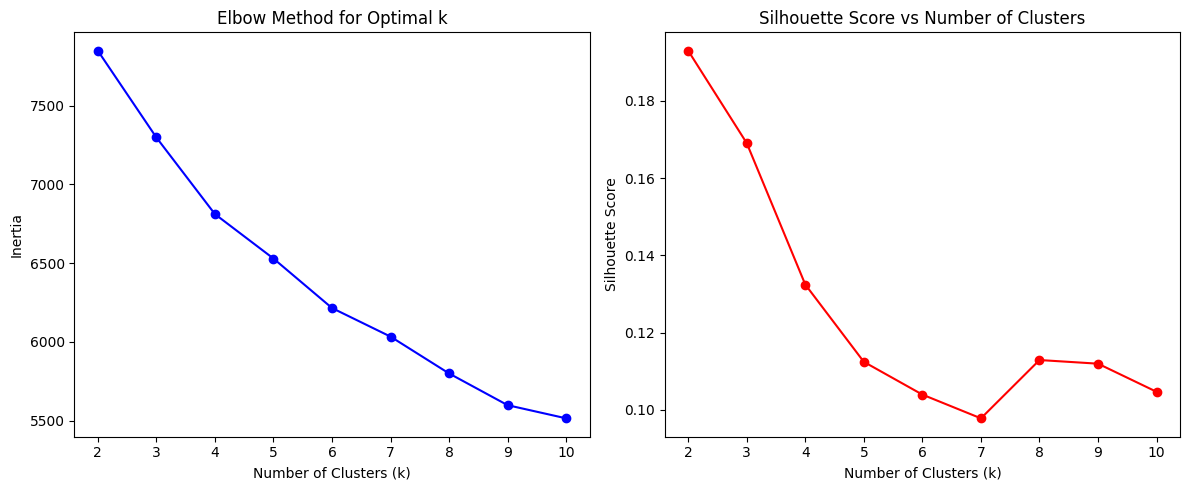

In [51]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

plt.tight_layout()
plt.show()

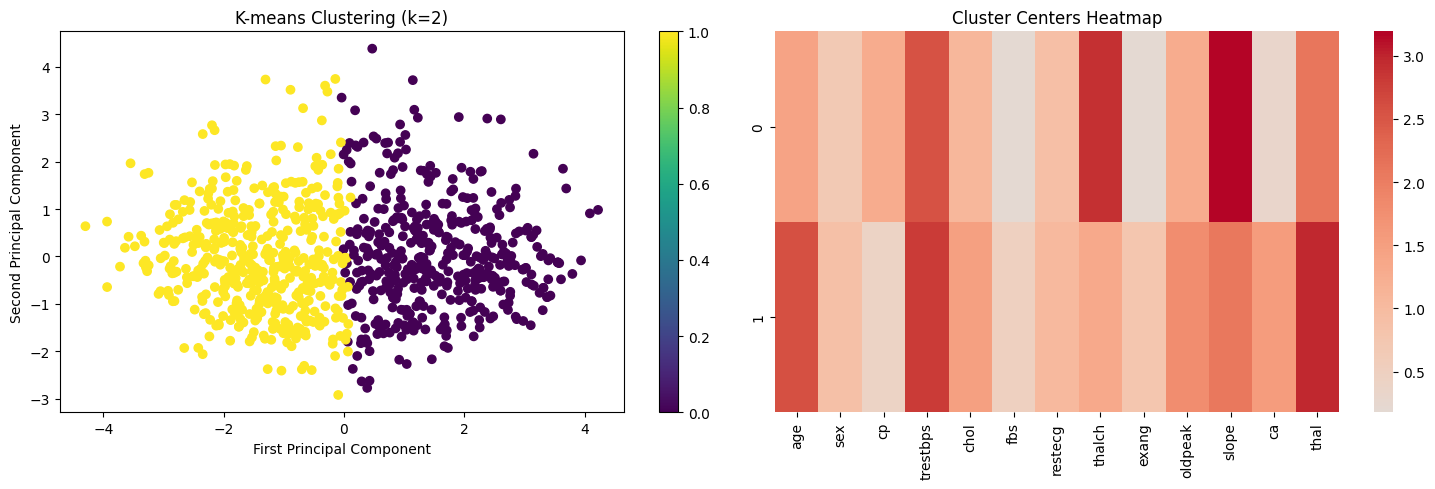

In [52]:
optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(15, 5))

# Cluster visualization
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-means Clustering (k={optimal_k})')
plt.colorbar(scatter)

# Cluster centers heatmap
plt.subplot(1, 2, 2)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
sns.heatmap(cluster_centers, cmap='coolwarm', center=0)
plt.title('Cluster Centers Heatmap')

plt.tight_layout()
plt.show()

In [53]:
X_with_clusters = X.copy()
X_with_clusters['Cluster'] = cluster_labels

print("\nCluster Analysis:")
print(f"Optimal number of clusters: {optimal_k}")
print(f"Final Silhouette Score: {silhouette_scores[optimal_k-2]:.3f}")

print("\nCluster Characteristics:")
for i in range(optimal_k):
    cluster_data = X_with_clusters[X_with_clusters['Cluster'] == i]
    print(f"\nCluster {i} size: {len(cluster_data)}")
    
    # Top features for this cluster
    cluster_mean = cluster_data.mean()
    top_features = cluster_mean.drop('Cluster').nlargest(3)
    print("Top features (highest mean values):")
    for feat, val in top_features.items():
        print(f"{feat}: {val:.3f}")


Cluster Analysis:
Optimal number of clusters: 2
Final Silhouette Score: 0.193

Cluster Characteristics:

Cluster 0 size: 440
Top features (highest mean values):
slope: 3.193
thalch: 2.902
trestbps: 2.548

Cluster 1 size: 480
Top features (highest mean values):
thal: 2.979
trestbps: 2.804
age: 2.571


In [ ]:
def perform_clustering_analysis(X):
    # Determine optimal number of clusters
    k_range = range(2, 11)
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Find optimal k using silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # Fit final model with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # Elbow curve
    plt.subplot(2, 2, 1)
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    
    # Silhouette score
    plt.subplot(2, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    
    # PCA visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Cluster visualization
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'K-means Clustering (k={optimal_k})')
    plt.colorbar(scatter)
    
    # Feature importance for clusters
    cluster_centers = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=X.columns
    )
    
    # Heatmap of cluster centers
    plt.subplot(2, 2, 4)
    sns.heatmap(cluster_centers, cmap='coolwarm', center=0)
    plt.title('Cluster Centers Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze clusters
    X_with_clusters = X.copy()
    X_with_clusters['Cluster'] = cluster_labels
    
    print("\nCluster Analysis:")
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Final Silhouette Score: {silhouette_scores[optimal_k-2]:.3f}")
    
    # Cluster characteristics
    print("\nCluster Characteristics:")
    for i in range(optimal_k):
        cluster_data = X_with_clusters[X_with_clusters['Cluster'] == i]
        print(f"\nCluster {i} size: {len(cluster_data)}")
        
        # Top features for this cluster
        cluster_mean = cluster_data.mean()
        top_features = cluster_mean.drop('Cluster').nlargest(3)
        print("Top features (highest mean values):")
        for feat, val in top_features.items():
            print(f"{feat}: {val:.3f}")
    
    return {
        'kmeans': kmeans,
        'optimal_k': optimal_k,
        'labels': cluster_labels,
        'silhouette_scores': silhouette_scores,
        'inertias': inertias,
        'cluster_centers': cluster_centers
    }

def tune_hyperparameters(X, y):
    param_grids = {
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 9],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42),
            'params': {
                'C': [0.1, 1.0, 10.0],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }
        }
    }
    
    best_params = {}
    
    for name, config in param_grids.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        grid_search.fit(X, y)
        
        best_params[name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    return best_params

In [122]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': conf_matrix,
        'model': model
    }

In [123]:
results = {}

for name, model_info in models.items():
    print(f"\nTraining {name}...")

    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    results[name] = evaluate_model(name, grid_search.best_estimator_, 
                                 X_test_scaled, y_test)


Training Decision Tree...


/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


Training Random Forest...


/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita


Training Naive Bayes...

Training Logistic Regression...

Training KNN...

Training Neural Network...


/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

In [124]:
print(f"\nBest parameters for {name}:")
print(grid_search.best_params_)
print(f"\nCross-validation score: {grid_search.best_score_:.4f}")
print(f"Test set accuracy: {results[name]['accuracy']:.4f}")
print("\nClassification Report:")
print(results[name]['report'])


Best parameters for Neural Network:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}

Cross-validation score: 0.6087
Test set accuracy: 0.6141

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        82
           1       0.56      0.55      0.55        53
           2       0.30      0.36      0.33        22
           3       0.45      0.48      0.47        21
           4       0.14      0.17      0.15         6

    accuracy                           0.61       184
   macro avg       0.46      0.47      0.46       184
weighted avg       0.63      0.61      0.62       184



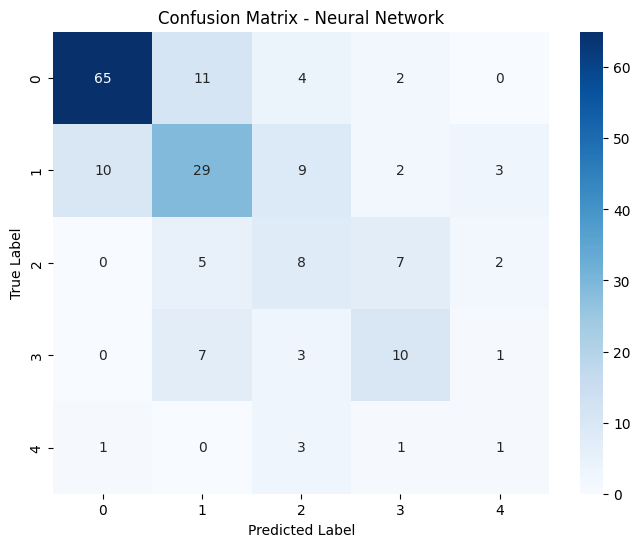

In [125]:
plt.figure(figsize=(8, 6))
sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

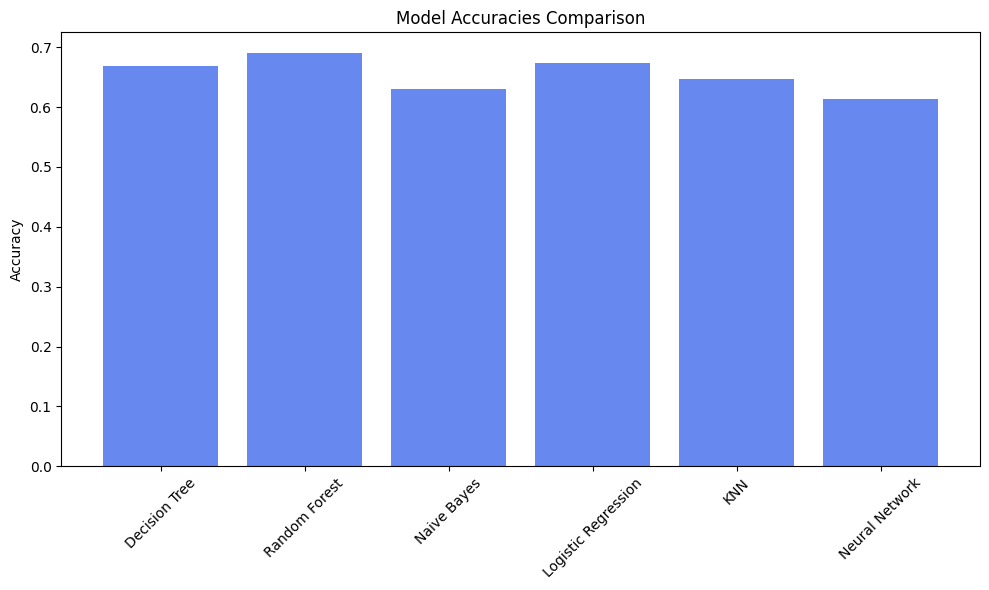

In [126]:
accuracies = {name: result['accuracy'] for name, result in results.items()}
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Model Accuracies Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [127]:
print("\nFinal Model Comparison:")
for name, accuracy in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {accuracy:.4f}")


Final Model Comparison:
Random Forest: 0.6902
Logistic Regression: 0.6739
Decision Tree: 0.6685
KNN: 0.6467
Naive Bayes: 0.6304
Neural Network: 0.6141


## Implementation 2

### Changing the binary string values to numeric values

In [8]:
uci_data['sex'] = uci_data['sex'].map({'Male': 1, 'Female': 0})

In [9]:
uci_data['exang'] = uci_data['exang'].map({True: 1, False: 0})

### Handling null values in the attributes
- thal - fixed by imputing the mode value
- fbs - fixed by imputing the mode value

In [10]:
uci_data['thal'].unique()

array(['fixed defect', 'normal', 'reversable defect', nan], dtype=object)

In [11]:
uci_data['thal'].fillna(uci_data['thal'].mode()[0], inplace=True)

In [12]:
uci_data['thal'].isnull().sum()

0

In [13]:
uci_data['fbs'].fillna(uci_data['fbs'].mode()[0], inplace=True)

In [14]:
uci_data['restecg'].fillna(uci_data['restecg'].mode()[0], inplace=True)

In [15]:
uci_data['exang'].fillna(uci_data['exang'].mode()[0], inplace=True)

In [16]:
uci_data['slope'].fillna(uci_data['slope'].mode()[0], inplace=True)

In [17]:
imputer = KNNImputer(n_neighbors=5)
uci_data[['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']] = imputer.fit_transform(uci_data[['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']])

In [18]:
uci_data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### Applying One-Hot encoding to the cp, restecg, thal and slope values

In [19]:
print(uci_data['cp'].unique())
print(uci_data['restecg'].unique())
print(uci_data['slope'].unique())
print(uci_data['thal'].unique())

['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
['lv hypertrophy' 'normal' 'st-t abnormality']
['downsloping' 'flat' 'upsloping']
['fixed defect' 'normal' 'reversable defect']


In [20]:
uci_data = pd.get_dummies(uci_data, columns=['cp'], drop_first=True)
uci_data = pd.get_dummies(uci_data, columns=['restecg'], drop_first=True)
uci_data = pd.get_dummies(uci_data, columns=['slope'], drop_first=True)
uci_data = pd.get_dummies(uci_data, columns=['thal'], drop_first=True)

### Correlation
High correlations with the target('num') column can be seen with ca(major vessels coolured by fluoroscopy) and oldpeak(ST depression). 
thalach (maximum heart rate) is negatively correlated with age, suggesting that the maximum heart rate generally declines with age.
age also seems to have a better correlation to num
trestbps has a very low correlation with the target, but it has a moderate correlation with age, since bp often increases with age

Tests: can check with and without the age feature

In [21]:
corr_matrix = uci_data.corr(numeric_only=True)

<Axes: >

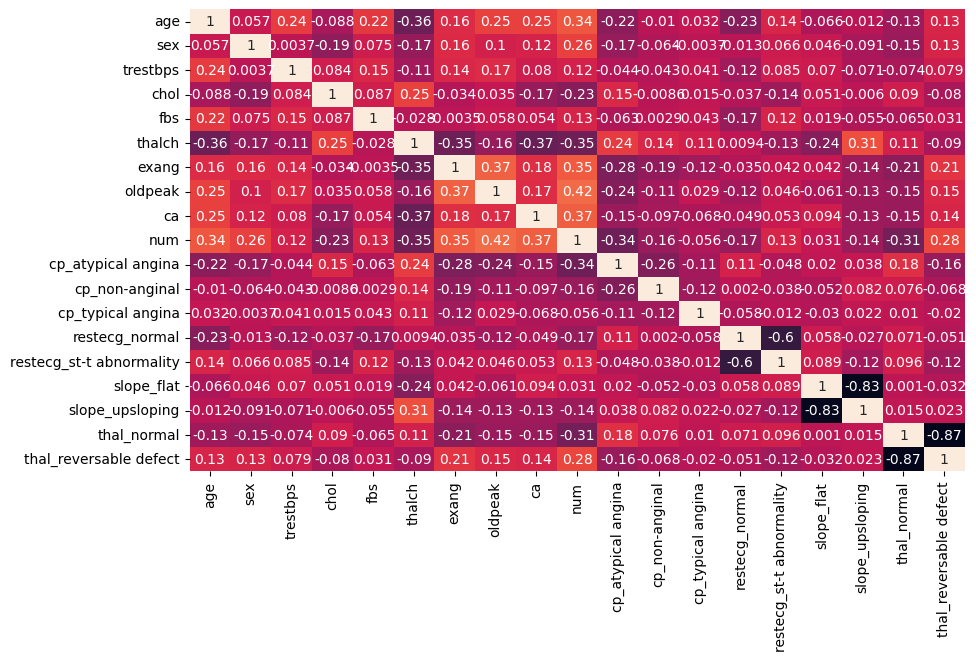

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cbar=False)

In [23]:
corr_matrix['num']

age                         0.339596
sex                         0.259342
trestbps                    0.115229
chol                       -0.228976
fbs                         0.129539
thalch                     -0.349587
exang                       0.350567
oldpeak                     0.421827
ca                          0.367073
num                         1.000000
cp_atypical angina         -0.343266
cp_non-anginal             -0.156050
cp_typical angina          -0.055896
restecg_normal             -0.168309
restecg_st-t abnormality    0.131698
slope_flat                  0.031161
slope_upsloping            -0.142565
thal_normal                -0.310862
thal_reversable defect      0.278313
Name: num, dtype: float64

### Splitting into train and test data

In [5]:
X = uci_data.drop('num', axis=1)
y = uci_data['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Training a Decision Tree to evaluate the Features
According to the Decision Tree obtained, it seems that the features: age, thalch, and chol are the most important in the dataset. From this, it can be assumed that these features might have a more significant influence on the intensity of the heart disease(0,1,2,3,4), followed by the moderately important features like trestbps, oldpeak and exang

In [25]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

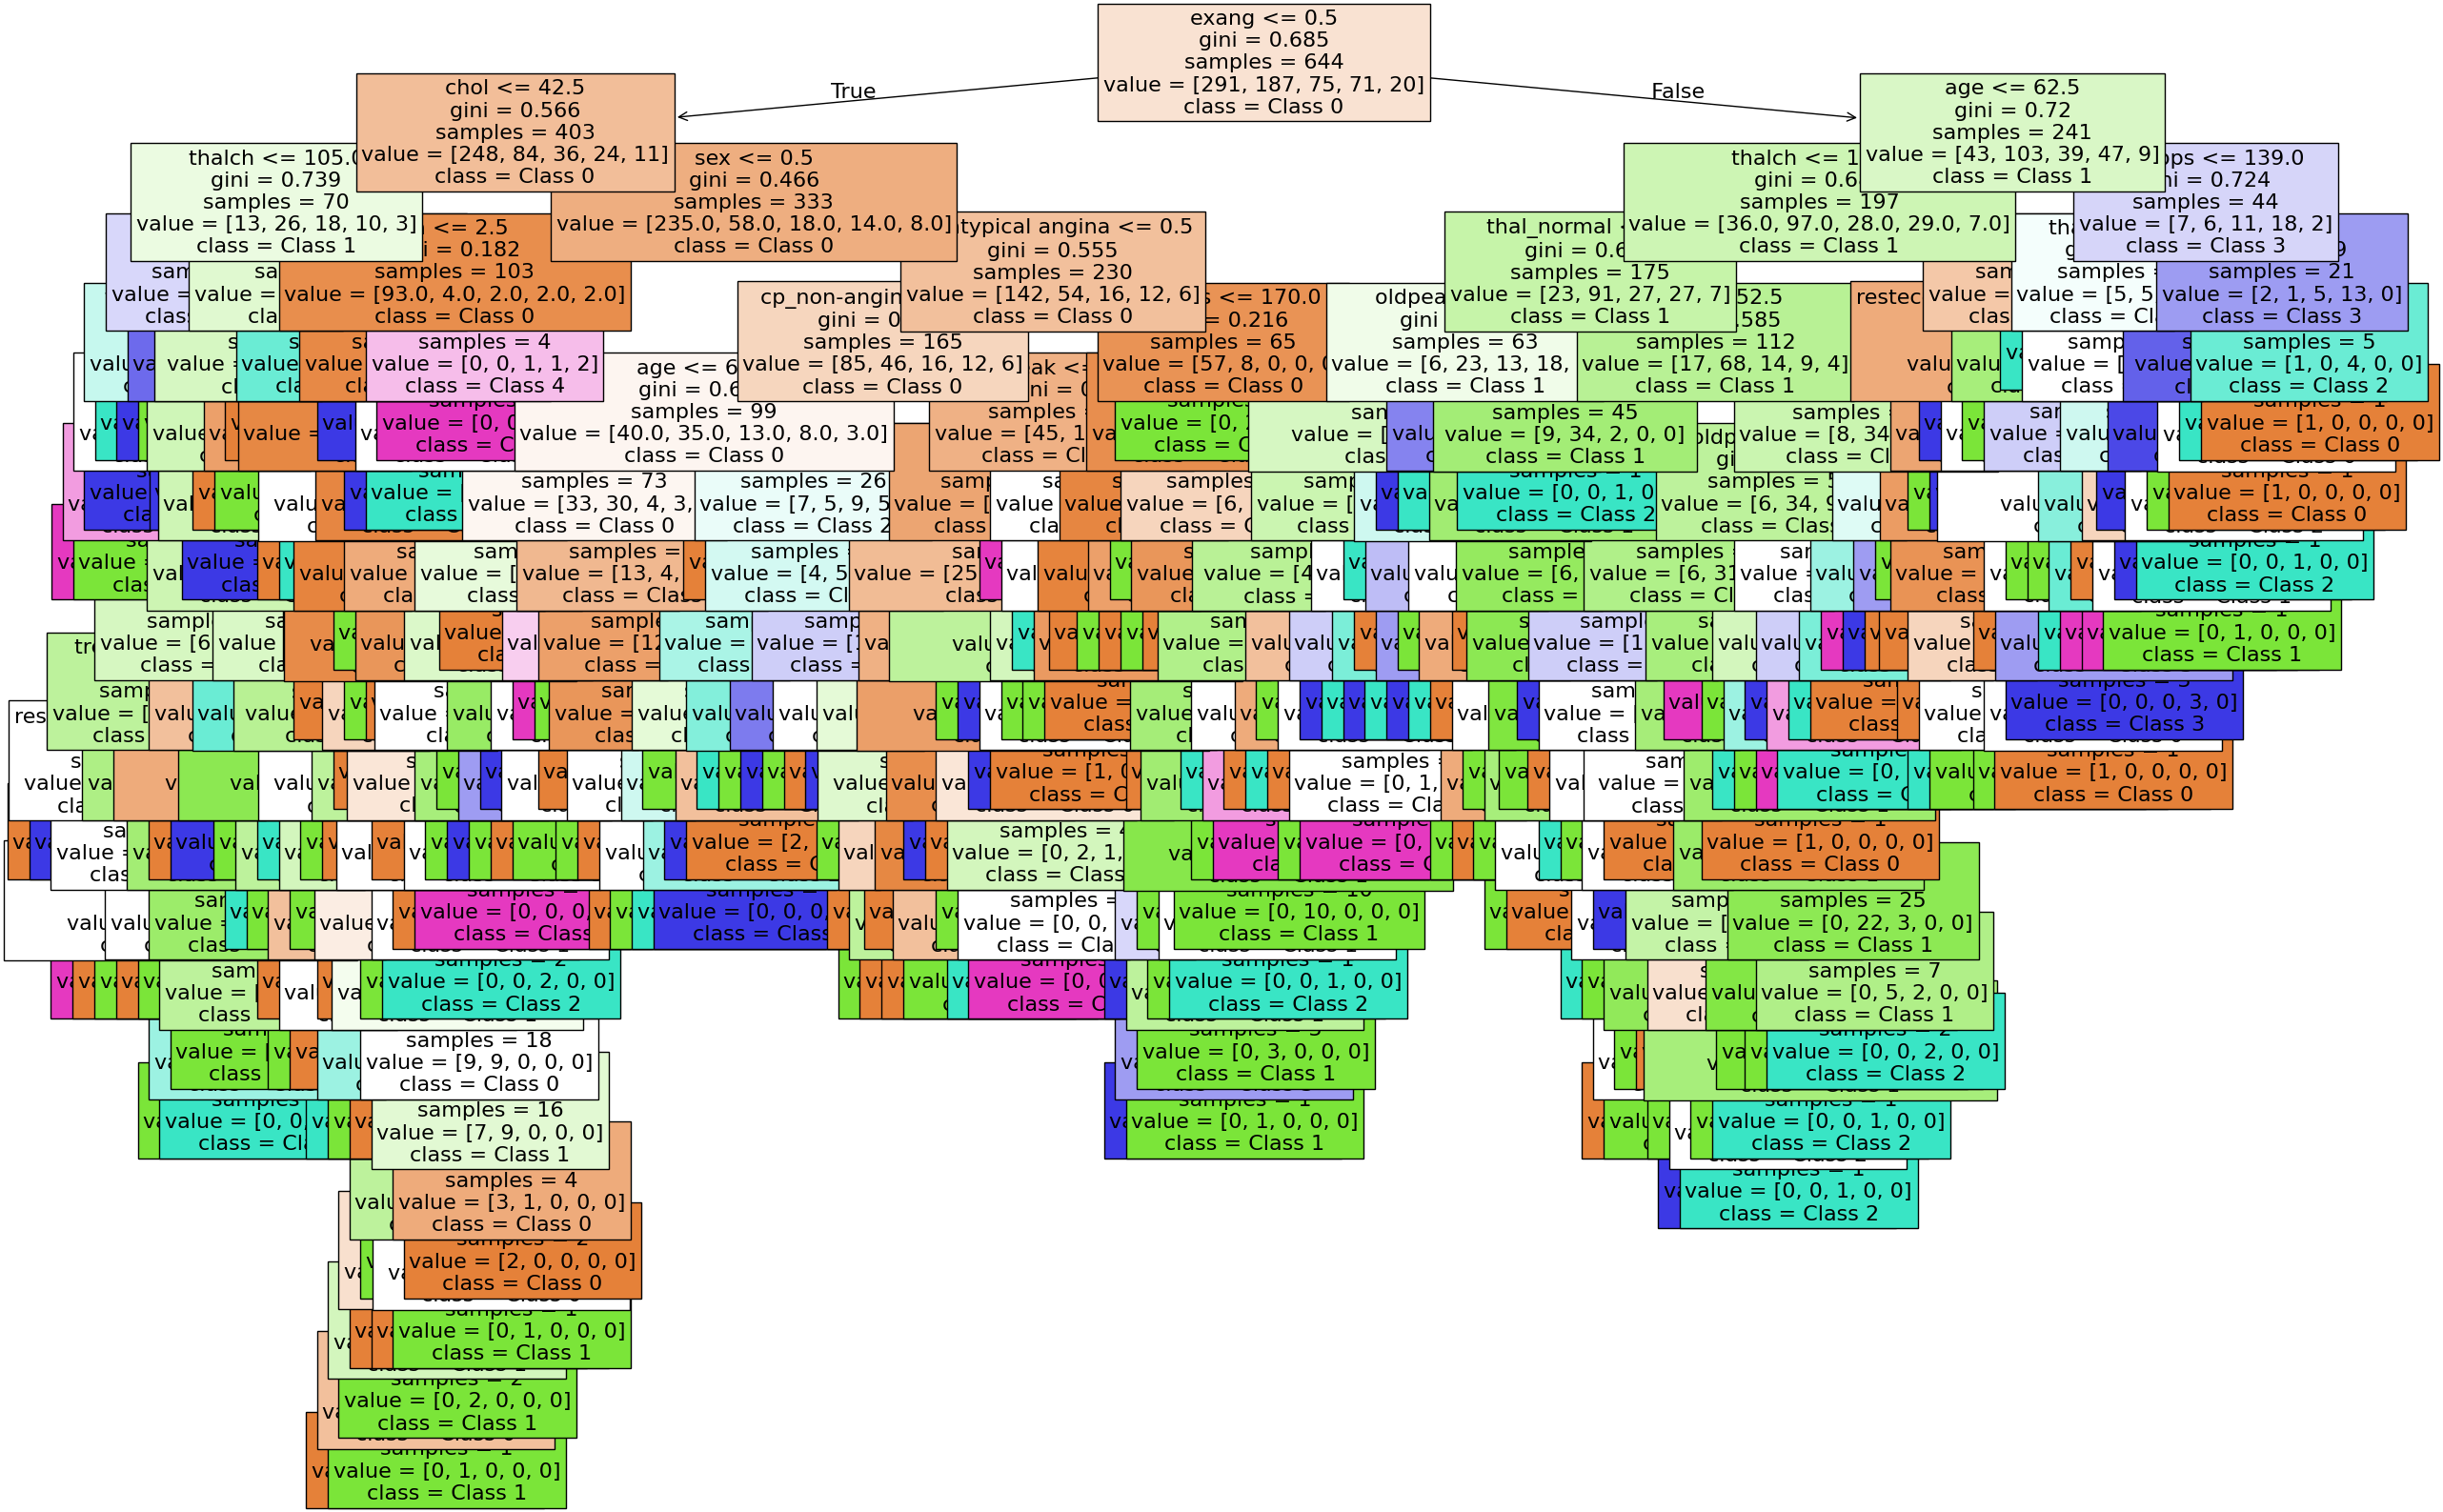

In [26]:
# Plot the decision tree
plt.figure(figsize=(30, 20))  # Adjust the size of the plot as needed
plot_tree(tree_model, feature_names=X.columns, class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], filled=True, fontsize=16)
plt.show()

In [27]:
importances = tree_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                     Feature  Importance
0                        age    0.144358
5                     thalch    0.136550
3                       chol    0.132745
2                   trestbps    0.117389
7                    oldpeak    0.115935
6                      exang    0.089792
8                         ca    0.074282
1                        sex    0.027763
9         cp_atypical angina    0.026545
14                slope_flat    0.025996
13  restecg_st-t abnormality    0.024796
15           slope_upsloping    0.018366
12            restecg_normal    0.017864
10            cp_non-anginal    0.017593
16               thal_normal    0.015565
4                        fbs    0.008163
17    thal_reversable defect    0.006298
11         cp_typical angina    0.000000


### Removing a few features based on the Decision Tree

In [179]:
uci_data.head()

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,1,145.0,233.0,True,150.0,0.0,2.3,0.0,0,False,False,True,False,False,False,False,False,False
1,67,1,160.0,286.0,False,108.0,1.0,1.5,3.0,2,False,False,False,False,False,True,False,True,False
2,67,1,120.0,229.0,False,129.0,1.0,2.6,2.0,1,False,False,False,False,False,True,False,False,True
3,37,1,130.0,250.0,False,187.0,0.0,3.5,0.0,0,False,True,False,True,False,False,False,True,False
4,41,0,130.0,204.0,False,172.0,0.0,1.4,0.0,0,True,False,False,False,False,False,True,True,False


In [180]:
uci_data.drop(columns=['cp_typical angina', 'thal_reversable defect', 'fbs'], inplace=True)

In [206]:
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [207]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=150),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Naive Bayes': GaussianNB(),
    "MLP Neural Network": MLPClassifier()
}
performance = {}

for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    performance[name] = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    }

performance_df = pd.DataFrame(performance).T

/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [208]:
performance_df

,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.543478,0.462703,0.543478,0.496946
K-Nearest Neighbors,0.561594,0.509951,0.561594,0.526436
Random Forest,0.579710,0.526785,0.579710,0.545559
Support Vector Classifier,0.543478,0.440129,0.543478,0.477057
Naive Bayes,0.224638,0.460953,0.224638,0.267186
MLP Neural Network,0.554348,0.497552,0.554348,0.518831


### Dropping the more features

In [196]:
uci_data.drop(columns=['sex'], inplace=True)

In [198]:
performance_df

,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.543478,0.487962,0.543478,0.507175
K-Nearest Neighbors,0.557971,0.500855,0.557971,0.517372
Random Forest,0.554348,0.496325,0.554348,0.519037
Support Vector Classifier,0.550725,0.446734,0.550725,0.490220
Naive Bayes,0.221014,0.459835,0.221014,0.263783
MLP Neural Network,0.565217,0.527174,0.565217,0.542656


In [200]:
uci_data.drop(columns=['cp_atypical angina', 'slope_flat', 'restecg_st-t abnormality', 'slope_upsloping', 'restecg_normal', 'cp_non-anginal', 'thal_normal'], inplace=True)

In [203]:
performance_df

,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.543478,0.487962,0.543478,0.507175
K-Nearest Neighbors,0.557971,0.500855,0.557971,0.517372
Random Forest,0.557971,0.505103,0.557971,0.523405
Support Vector Classifier,0.550725,0.446734,0.550725,0.490220
Naive Bayes,0.221014,0.459835,0.221014,0.263783
MLP Neural Network,0.554348,0.519635,0.554348,0.534075


### Test

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Select the most important features based on correlation and feature importance
important_features = [
    'age', 'thalch', 'chol', 'trestbps', 'oldpeak', 
    'exang', 'ca', 'cp_atypical angina', 'thal_normal'
]

def build_optimized_model(X, y):
    # Keep only important features
    X_selected = X[important_features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Create pipeline with SMOTE
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
    
    # Define parameter distributions for randomized search
    param_distributions = {
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(3, 10),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 10),
        'classifier__subsample': uniform(0.6, 0.4)
    }
    
    # Perform randomized search
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=50,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    
    # Print results
    print("\nBest parameters:", random_search.best_params_)
    print("\nBest cross-validation score:", random_search.best_score_)
    print("\nTest set performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Perform k-fold cross validation on the entire dataset
    cv_scores = cross_val_score(best_model, X_selected, y, cv=5)
    print("\nCross-validation scores:", cv_scores)
    print("Average CV score: {:.3f} (+/- {:.3f})".format(
        cv_scores.mean(), cv_scores.std() * 2
    ))
    
    return best_model

# Function to analyze target distribution
def analyze_target_distribution(y):
    print("\nTarget Distribution:")
    dist = pd.Series(y).value_counts().sort_index()
    print(dist)
    print("\nPercentage Distribution:")
    print((dist / len(y) * 100).round(2))


In [21]:
X = uci_data.drop('num', axis=1)
y = uci_data['num']

In [23]:
# analyze_target_distribution(y)


Target Distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Percentage Distribution:
num
0    44.67
1    28.80
2    11.85
3    11.63
4     3.04
Name: count, dtype: float64


In [24]:
# Then train and evaluate the model
# best_model = build_optimized_model(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters: {'classifier__learning_rate': 0.010156113098594747, 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 9, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 458, 'classifier__subsample': 0.6658623412571767}

Best cross-validation score: 0.5434454863026291

Test set performance:
Accuracy: 0.5706521739130435

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        82
           1       0.47      0.43      0.45        53
           2       0.50      0.50      0.50        22
           3       0.33      0.38      0.36        21
           4       0.12      0.17      0.14         6

    accuracy                           0.57       184
   macro avg       0.44      0.45      0.44       184
weighted avg       0.58      0.57      0.57       184


Cross-validation scores: [0.48369565 0.45652174 0.53804348 0.4076087  0.3315

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

def build_balanced_model(X, y):
    # Important features based on correlation and importance
    important_features = [
        'age', 'thalch', 'chol', 'trestbps', 'oldpeak', 
        'exang', 'ca', 'cp_atypical angina', 'thal_normal'
    ]
    
    X_selected = X[important_features]
    
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    # Create pipeline with SMOTENC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTENC(
            categorical_features=[X_selected.columns.get_loc('exang')],
            sampling_strategy={
                0: 100,  # Specify number of samples for each class
                1: 100,
                2: 100,
                3: 100,
                4: 100
            },
            random_state=42,
            k_neighbors=3  # Reduced due to small class sizes
        )),
        ('classifier', GradientBoostingClassifier(
            random_state=42
        ))
    ])
    
    # Define parameter distributions
    param_distributions = {
        'classifier__n_estimators': randint(200, 600),
        'classifier__learning_rate': uniform(0.001, 0.1),
        'classifier__max_depth': randint(3, 8),
        'classifier__min_samples_split': randint(2, 10),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__subsample': uniform(0.7, 0.3)
    }
    
    # Perform randomized search with stratified k-fold
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=50,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    
    # Print results
    print("\nBest parameters:", random_search.best_params_)
    print("\nBest cross-validation score:", random_search.best_score_)
    print("\nTest set performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Perform stratified k-fold cross validation
    cv_scores = cross_val_score(
        best_model, 
        X_selected, 
        y, 
        cv=5, 
        scoring='balanced_accuracy'
    )
    print("\nCross-validation scores (balanced accuracy):", cv_scores)
    print("Average CV score: {:.3f} (+/- {:.3f})".format(
        cv_scores.mean(), cv_scores.std() * 2
    ))
    
    return best_model

# Function to analyze class distribution
def analyze_class_distribution(y):
    print("\nClass Distribution:")
    dist = pd.Series(y).value_counts().sort_index()
    print(dist)
    print("\nPercentage Distribution:")
    print((dist / len(y) * 100).round(2))
    
    # Calculate and print the imbalance ratio
    majority_class = dist.max()
    minority_class = dist.min()
    print(f"\nImbalance ratio (majority:minority): {majority_class/minority_class:.2f}:1")

# Alternative approach using BalancedRandomForestClassifier
def build_balanced_rf_model(X, y):
    from imblearn.ensemble import BalancedRandomForestClassifier
    
    # Use the same important features
    important_features = [
        'age', 'thalch', 'chol', 'trestbps', 'oldpeak', 
        'exang', 'ca', 'cp_atypical angina', 'thal_normal'
    ]
    
    X_selected = X[important_features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    # Create and fit the model
    clf = BalancedRandomForestClassifier(
        n_estimators=500,
        random_state=42,
        sampling_strategy='balanced',
        n_jobs=-1
    )
    
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test)
    print("\nBalanced Random Forest Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

# Run the analysis and both models
print("Initial class distribution:")
analyze_class_distribution(y)

print("\nTraining Gradient Boosting model...")
gb_model = build_balanced_model(X, y)

print("\nTraining Balanced Random Forest model...")
rf_model = build_balanced_rf_model(X, y)

Initial class distribution:

Class Distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Percentage Distribution:
num
0    44.67
1    28.80
2    11.85
3    11.63
4     3.04
Name: count, dtype: float64

Imbalance ratio (majority:minority): 14.68:1

Training Gradient Boosting model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/base.py", line 108, in fit_resample
    self.sampling_strategy_ = check_sampling_strategy(
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/utils/_validation.py", line 557, in check_sampling_strategy
    sorted(_sampling_strategy_dict(sampling_strategy, y, sampling_type).items())
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/utils/_validation.py", line 335, in _sampling_strategy_dict
    raise ValueError(
ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 264 samples and 100 samples are asked.

--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/base.py", line 108, in fit_resample
    self.sampling_strategy_ = check_sampling_strategy(
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/utils/_validation.py", line 557, in check_sampling_strategy
    sorted(_sampling_strategy_dict(sampling_strategy, y, sampling_type).items())
  File "/Users/harika/miniconda3/envs/pyenv/lib/python3.10/site-packages/imblearn/utils/_validation.py", line 335, in _sampling_strategy_dict
    raise ValueError(
ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 263 samples and 100 samples are asked.
